In [1]:
!pip install git+https://github.com/Cupcakus/pafy

  Running command git clone -q https://github.com/Cupcakus/pafy 'C:\Users\HA\AppData\Local\Temp\pip-req-build-xm29jq_f'



  Cloning https://github.com/Cupcakus/pafy to c:\users\ha\appdata\local\temp\pip-req-build-xm29jq_f
  Resolved https://github.com/Cupcakus/pafy to commit 45f0deb067bf7c420cdf83a0529fd5274c12de18


In [2]:
import cv2
import youtube_dl
import pafy
import numpy as np
import matplotlib.pyplot as plt
import time

url = 'https://www.youtube.com/watch?v=ipyzW38sHg0'
video = pafy.new(url)
best = video.getbest(preftype = 'mp4')

cap = cv2.VideoCapture(best.url)

ym_per_pix = 30 / 720
xm_per_pix = 3.7 / 720


frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out1 = cv2.VideoWriter('C:\\Users\\bit\\Desktop\\opencv_youtube.mp4', fourcc, 20.0, frame_size)

def color_filter(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    lower = np.array([20, 150, 20])
    upper = np.array([255, 255, 255])

    yellow_lower = np.array([0, 85, 81])
    yellow_upper = np.array([190, 255, 255])

    yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)
    white_mask = cv2.inRange(hls, lower, upper)
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)

    return masked

def roi(image):
    x = int(image.shape[1])
    y = int(image.shape[0])

    # 한 붓 그리기
    _shape = np.array(
        [[int(0.1*x), int(y)], [int(0.1*x), int(0.1*y)], [int(0.4*x), int(0.1*y)], [int(0.4*x), int(y)], [int(0.7*x), int(y)], [int(0.7*x), int(0.1*y)],[int(0.9*x), int(0.1*y)], [int(0.9*x), int(y)], [int(0.2*x), int(y)]])

    mask = np.zeros_like(image)

    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, np.int32([_shape]), ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)

    return masked_image

def wrapping(image):
    (h, w) = (image.shape[0], image.shape[1])

    source = np.float32([[w // 2 - 30, h * 0.53], [w // 2 + 60, h * 0.53], [w * 0.3, h], [w, h]])
    destination = np.float32([[0, 0], [w-350, 0], [400, h], [w-150, h]])

    transform_matrix = cv2.getPerspectiveTransform(source, destination)
    minv = cv2.getPerspectiveTransform(destination, source)
    _image = cv2.warpPerspective(image, transform_matrix, (w, h))

    return _image, minv

def plothistogram(image):
    histogram = np.sum(image[image.shape[0]//2:, :], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftbase = np.argmax(histogram[:midpoint])
    rightbase = np.argmax(histogram[midpoint:]) + midpoint

    return leftbase, rightbase

def slide_window_search(binary_warped, left_current, right_current):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    nwindows = 4
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()  # 선이 있는 부분의 인덱스만 저장
    nonzero_y = np.array(nonzero[0])  # 선이 있는 부분 y의 인덱스 값
    nonzero_x = np.array(nonzero[1])  # 선이 있는 부분 x의 인덱스 값
    margin = 100
    minpix = 50
    left_lane = []
    right_lane = []
    color = [0, 255, 0]
    thickness = 2

    for w in range(nwindows):
        win_y_low = binary_warped.shape[0] - (w + 1) * window_height  # window 윗부분
        win_y_high = binary_warped.shape[0] - w * window_height  # window 아랫 부분
        win_xleft_low = left_current - margin  # 왼쪽 window 왼쪽 위
        win_xleft_high = left_current + margin  # 왼쪽 window 오른쪽 아래
        win_xright_low = right_current - margin  # 오른쪽 window 왼쪽 위
        win_xright_high = right_current + margin  # 오른쪽 window 오른쪽 아래

        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), color, thickness)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), color, thickness)
        good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        left_lane.append(good_left)
        right_lane.append(good_right)
        cv2.imshow("oo", out_img)

        if len(good_left) > minpix:
            left_current = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > minpix:
            right_current = np.int(np.mean(nonzero_x[good_right]))

    left_lane = np.concatenate(left_lane)  # np.concatenate() -> array를 1차원으로 합침
    right_lane = np.concatenate(right_lane)

    leftx = nonzero_x[left_lane]
    lefty = nonzero_y[left_lane]
    rightx = nonzero_x[right_lane]
    righty = nonzero_y[right_lane]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    ltx = np.trunc(left_fitx)  # np.trunc() -> 소수점 부분을 버림
    rtx = np.trunc(right_fitx)

    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

    ret = {'left_fitx' : ltx, 'right_fitx': rtx, 'ploty': ploty}

    return ret

def draw_lane_lines(original_image, warped_image, Minv, draw_info):
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (216, 168, 74))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (216, 168, 74))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0]))
    result = cv2.addWeighted(original_image, 1, newwarp, 0.4, 0)

    return pts_mean, result

## Sliding Window 표시

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

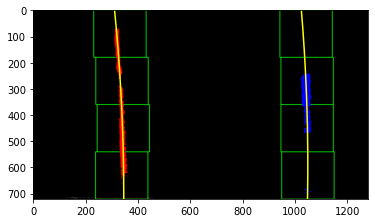

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

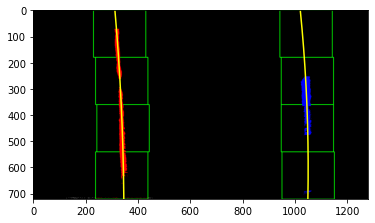

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

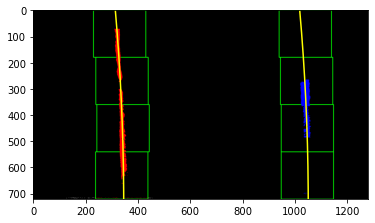

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

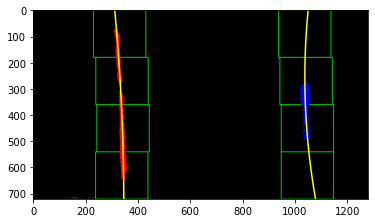

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

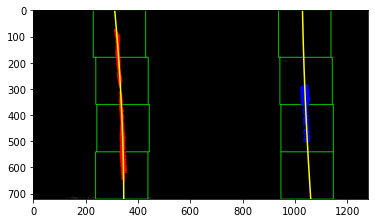

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

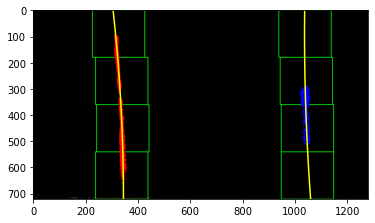

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

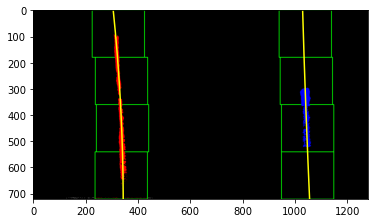

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

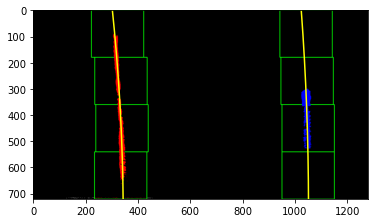

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

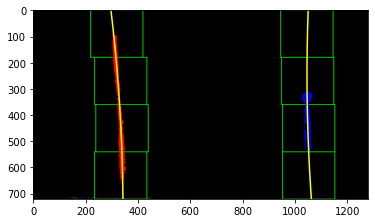

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

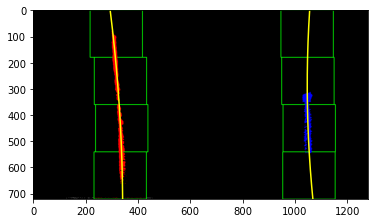

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

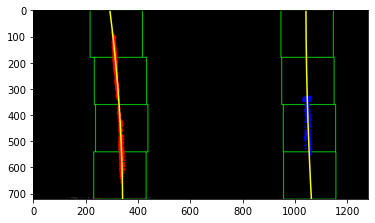

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

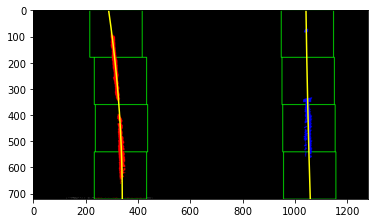

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

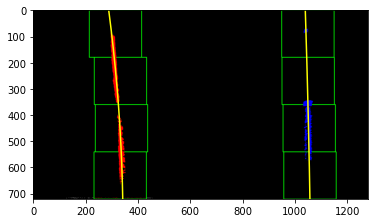

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

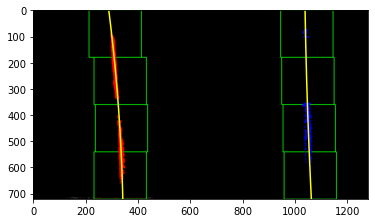

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

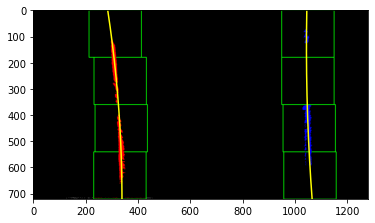

C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
C:\Users\HA\AppData\Local\Temp\ipykernel_11468\4116909351.py:84: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

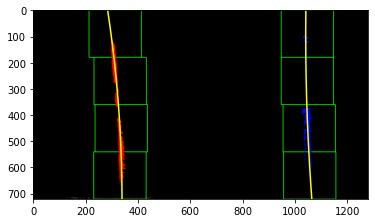

In [3]:
while True:
    retval, img = cap.read()
    if not retval:
        break

    ## 조감도 wrapped img
    wrapped_img, minverse = wrapping(img)
    #cv2.imshow('wrapped', wrapped_img)
    ## 조감도 필터링
    w_f_img = color_filter(wrapped_img)
    # cv2.imshow('w_f_img', w_f_img)

    ##조감도 필터링 자르기
    w_f_r_img = roi(w_f_img)
    # cv2.imshow('w_f_r_img', w_f_r_img)

    ## 조감도 선 따기 wrapped img threshold
    _gray = cv2.cvtColor(w_f_r_img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(_gray, 160, 255, cv2.THRESH_BINARY)
    #cv2.imshow('threshold', thresh)
    ## 선 분포도 조사 histogram
    leftbase, rightbase = plothistogram(thresh)
    # plt.plot(hist)
    # plt.show()

    # histogram 기반 window roi 영역
    draw_info = slide_window_search(thresh, leftbase, rightbase)
    #plt.plot(left_fit)
    #plt.show()

    ## 원본 이미지에 라인 넣기
    #meanPts, result = draw_lane_lines(img, thresh, minverse, draw_info)
    #cv2.imshow("result", result)
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break


if cap.isOpened():
    cap.release()

cv2.destroyAllWindows()

## Lane Detection 도로 그리기

In [ ]:
while True:
    retval, img = cap.read()
    if not retval:
        break

    ## 조감도 wrapped img
    wrapped_img, minverse = wrapping(img)
    #cv2.imshow('wrapped', wrapped_img)
    ## 조감도 필터링
    w_f_img = color_filter(wrapped_img)
    # cv2.imshow('w_f_img', w_f_img)

    ##조감도 필터링 자르기
    w_f_r_img = roi(w_f_img)
    # cv2.imshow('w_f_r_img', w_f_r_img)

    ## 조감도 선 따기 wrapped img threshold
    _gray = cv2.cvtColor(w_f_r_img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(_gray, 160, 255, cv2.THRESH_BINARY)
    #cv2.imshow('threshold', thresh)
    ## 선 분포도 조사 histogram
    leftbase, rightbase = plothistogram(thresh)
    # plt.plot(hist)
    # plt.show()

    # histogram 기반 window roi 영역
    #draw_info = slide_window_search(thresh, leftbase, rightbase)
    #plt.plot(left_fit)
    #plt.show()

    ## 원본 이미지에 라인 넣기
    meanPts, result = draw_lane_lines(img, thresh, minverse, draw_info)
    cv2.imshow("result", result)
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break


if cap.isOpened():
    cap.release()

cv2.destroyAllWindows()